In [ ]:
# %pip install --upgrade -q "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()
# jax.devices()

In [ ]:
try :
    import flax.linen as nn
except:
    %pip install -q flax
    import flax.linen as nn

from flax.core import unfreeze

from flax.training import train_state 

import jax
import jax.numpy as jnp
from jax.config import config
import optax

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

from scipy.ndimage import rotate

import tensorflow.keras.datasets as tfds
# %pip install tensorflow_probability
import tensorflow_probability as tfp

from functools import partial
from tqdm import tqdm
import pandas as pd

In [ ]:
%env LATEXIFY= 1
%env FIG_DIR="figures/"

env: LATEXIFY=1
env: FIG_DIR="figures/"


In [ ]:
is_latexify_enabled()

True

In [ ]:
latexify(width_scale_factor=1, fig_height=2)

In [ ]:
dist = tfp.distributions

In [ ]:
config.update("jax_enable_x64", True)

In [ ]:
class LeNet(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):

        # 1 layer
        x = nn.Conv(features=6, kernel_size=(5, 5), name="conv2d_1")(x)
        # x = nn.tanh(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2))

        # 2 layer
        x = nn.Conv(features=16, kernel_size=(5, 5), name="conv2d_2")(x)
        # x = nn.tanh(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2))

        # 3 layer
        x = nn.Conv(features=120, kernel_size=(5, 5), name="conv2d_3")(x)
        # x = nn.tanh(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2))

        x = x.reshape((x.shape[0], -1))  # flatten
        # 4 fully connected layer
        x = nn.Dense(84, name="Dense_1_84")(x)
        # x = nn.tanh(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=deterministic)(x)

        # 5 fully connected layer
        x = nn.Dense(10, name="Dense_2_10")(x)
        # x = nn.softmax(x)

        return x

In [ ]:
def get_datasets():
    train_dataset, test_dataset = tfds.mnist.load_data()
    X_train, y_train = train_dataset
    x_test, y_test = test_dataset

    X_train = jnp.array(X_train / 255)
    x_test = jnp.array(x_test / 255)

    X_train = X_train[..., jnp.newaxis]
    x_test = x_test[..., jnp.newaxis]

    return [X_train, jnp.array(y_train)], [x_test, jnp.array(y_test)]

In [ ]:
def cross_entropy_loss(params, x, y, deterministic, rng=jax.random.PRNGKey(0)):
    labels_onehot = jax.nn.one_hot(y, num_classes=10)
    logits = model.apply(params, x, deterministic=deterministic, rngs={"dropout": rng})
    return (
        jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=labels_onehot)),
        logits,
    )

In [ ]:
def fit(params, X, Y, batch_size, learning_rate=0.01, epochs=10, verbose=False):
    # opt = optax.adamw(learning_rate=learning_rate)
    opt = optax.sgd(learning_rate, 0.75)
    opt_state = opt.init(params)

    lg_fn = jax.value_and_grad(cross_entropy_loss, has_aux=True)

    rng, _ = jax.random.split(jax.random.PRNGKey(0))
    losses = []

    train_ds_size = len(X)
    steps_per_epoch = train_ds_size // batch_size

    for i in range(epochs):
        rng, _ = jax.random.split(rng)

        @jax.jit
        def one_step(params, x, y, opt_state, rng):
            (loss_val, logits), grads = lg_fn(params, x, y, False, rng=rng)
            updates, opt_state = opt.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            acc_val = jnp.mean(jnp.argmax(logits, -1) == y)
            return params, opt_state, loss_val, logits, acc_val

        # _ , rng = jax.random.split(rng)
        perms = jax.random.permutation(rng, train_ds_size)
        perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
        perms = perms.reshape((steps_per_epoch, batch_size))
        accuracy = []
        losses = []

        for perm in perms:
            rng, _ = jax.random.split(rng)
            x, y = X[perm], Y[perm]
            params, opt_state, loss_val, logits, acc_val = one_step(
                params, x, y, opt_state, rng
            )
            losses.append(loss_val)
            accuracy.append(acc_val)

        # if verbose and i % (epochs/10) == 0:
        print(
            "train epoch: %d, loss: %.4f, accuracy: %.2f"
            % (i, jnp.mean(jnp.array(losses)), jnp.mean(jnp.array(accuracy)))
        )
    return params, losses

In [ ]:
train_ds, test_ds = get_datasets()
X_train, y_train = train_ds
x_test, y_test = test_ds

In [ ]:
batch = 32
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
model = LeNet()
params = model.init(init_rng, jnp.ones([1, 28, 28, 1]), deterministic=True)

In [ ]:
params, losses = fit(params, X_train, y_train, batch, learning_rate=0.003, epochs=10)

train epoch: 0, loss: 0.3680, accuracy: 0.89
train epoch: 1, loss: 0.1323, accuracy: 0.96
train epoch: 2, loss: 0.0984, accuracy: 0.97
train epoch: 3, loss: 0.0805, accuracy: 0.98
train epoch: 4, loss: 0.0694, accuracy: 0.98
train epoch: 5, loss: 0.0611, accuracy: 0.98
train epoch: 6, loss: 0.0560, accuracy: 0.98
train epoch: 7, loss: 0.0490, accuracy: 0.99
train epoch: 8, loss: 0.0463, accuracy: 0.99
train epoch: 9, loss: 0.0413, accuracy: 0.99


In [ ]:
pd.to_pickle(params, "mnist_params.pkl")

# Figure

In [ ]:
one_img = x_test[2]
one_img = rotate(one_img, 30, reshape=False)

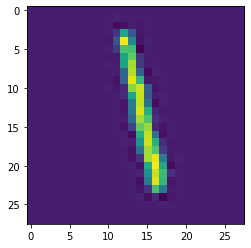

In [ ]:
plt.imshow(one_img.squeeze())

In [ ]:
imgs = jnp.array([rotate(one_img, 5.5 * i, reshape=False) for i in range(12)])

In [ ]:
# for i in imgs:
#   plt.imshow(i.squeeze())
#   plt.show()

In [ ]:
pred = model.apply(
    params, imgs, deterministic=False, rngs={"dropout": jax.random.PRNGKey(0)}
)
jnp.argmax(pred, axis=1)

DeviceArray([1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7], dtype=int64)

# MC Dropout

In [ ]:
n_stacks = 100
y_stacks = []
fn = lambda i: model.apply(
    params, imgs, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)}
)
y_stacks = jax.vmap(jax.jit(fn), in_axes=(0))(jnp.arange(n_stacks))

In [ ]:
stacks = y_stacks[:, :, (1, 3, 7)]

In [ ]:
mean = stacks.mean(axis=0)
std = stacks.std(axis=0)

In [ ]:
soft_stacks = nn.softmax(stacks, axis=-1)

In [ ]:
soft_mean = soft_stacks.mean(axis=0)
soft_std = soft_stacks.std(axis=0)

In [ ]:
def offset_image(coord, i, ax, low_img, low_index):
    img = imgs[i]
    im = OffsetImage(img.squeeze(), zoom=0.4)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        (coord, low_img),
        xybox=(0.0, low_index),
        frameon=False,
        boxcoords="offset points",
    )
    ax.add_artist(ab)

saving image to "figures/"/Mnist_with_MC_Dropout_latexified.pdf
Figure size: [6. 2.]


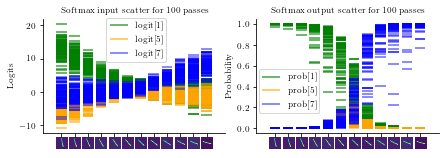

In [ ]:
if is_latexify_enabled():
    fig, ax = plt.subplots(1, 2)
else:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
index = jnp.arange(12)
for i in range(12):
    ax[0].eventplot(
        stacks[:, i, 0],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="green",
        alpha=0.75,
    )
    ax[0].eventplot(
        stacks[:, i, 1],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="orange",
        alpha=0.75,
    )
    ax[0].eventplot(
        stacks[:, i, 2],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="blue",
        alpha=0.6,
    )

ax[0].set_xticks(index)
ax[0].set_xticklabels(index + 1)
ax[0].tick_params(axis="x", which="major", pad=6)
ax[0].set_ylabel("Logits")
l, h = ax[0].get_ylim()
for i in index:
    offset_image(i, i, ax[0], l, l + 2)
ax[0].legend(["logit[1]", "logit[5]", "logit[7]"], bbox_to_anchor=(0.7, 1.05))
ax[0].set_title("Softmax input scatter for 100 passes")


for i in range(12):
    ax[1].eventplot(
        soft_stacks[:, i, 0].sort()[:75],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="green",
        alpha=0.75,
    )
    ax[1].eventplot(
        soft_stacks[:, i, 1].sort()[:75],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="orange",
        alpha=0.75,
    )
    ax[1].eventplot(
        soft_stacks[:, i, 2].sort()[:75],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="blue",
        alpha=0.6,
    )

ax[1].set_xticks(index)
ax[1].set_xticklabels(index + 1)
ax[1].tick_params(axis="x", which="major", pad=6)
ax[1].set_ylabel("Probability")
l, h = ax[1].get_ylim()
for i in index:
    offset_image(i, i, ax[1], l, l - 10)

ax[1].legend(["prob[1]", "prob[5]", "prob[7]"], loc="best", bbox_to_anchor=(0.37, 0.6))
ax[1].set_title("Softmax output scatter for 100 passes")

sns.despine()
savefig("Mnist_with_MC_Dropout", tight_bbox=True, pad=1)
plt.show()

# OOD FMnist

In [ ]:
def get_fmnist_datasets():
    train_dataset, test_dataset = tfds.fashion_mnist.load_data()
    X_train, y_train = train_dataset
    x_test, y_test = test_dataset

    # X_train = jnp.array(X_train/255)
    x_test = jnp.array(x_test / 255)

    # X_train = X_train[..., jnp.newaxis]
    x_test = x_test[..., jnp.newaxis]

    return [X_train, jnp.array(y_train)], [x_test, jnp.array(y_test)]

In [ ]:
_, test_fmnist_ds = get_fmnist_datasets()
x_test_fmnist, y_test_fmnist = test_fmnist_ds

In [ ]:
# 8
mnist_img = x_test[110]
fmnist_img = x_test_fmnist[1]

In [ ]:
mnist_img = mnist_img[jnp.newaxis, :, :, :]
fmnist_img = fmnist_img[jnp.newaxis, :, :, :]

In [ ]:
plt.imshow(fmnist_img.squeeze())

In [ ]:
n_stacks = 100
y_stacks = []
fn = lambda i, img: model.apply(
    params, img, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)}
)
y_mnist_stacks = jax.vmap(jax.jit(fn), in_axes=(0, None))(
    jnp.arange(n_stacks), mnist_img
)
y_fmnist_stacks = jax.vmap(jax.jit(fn), in_axes=(0, None))(
    jnp.arange(n_stacks), fmnist_img
)

In [ ]:
y_mnist_stacks = nn.softmax(y_mnist_stacks, axis=-1)
y_fmnist_stacks = nn.softmax(y_fmnist_stacks, axis=-1)

In [ ]:
mnist_mean, mnist_sigma = y_mnist_stacks.mean(axis=0), y_mnist_stacks.std(axis=0)
fmnist_mean, fmnist_sigma = y_fmnist_stacks.mean(axis=0), y_fmnist_stacks.std(axis=0)

In [ ]:
mnist_mean = mnist_mean.squeeze()
mnist_sigma = mnist_sigma.squeeze()
fmnist_mean = fmnist_mean.squeeze()
fmnist_sigma = fmnist_sigma.squeeze()

In [ ]:
y_mnist_stacks.shape

In [ ]:
y_mnist_stacks[:, 0, 8].min()

In [ ]:
sns.kdeplot(y_mnist_stacks[:, 0, 8], bw=1)
plt.show()

In [ ]:
plt.rc("font", size=20)
fig, ax = plt.subplots(2, 2, figsize=(20, 8))

ax[0, 0].imshow(mnist_img.squeeze())
idx = mnist_mean.argmax()
X = jnp.linspace(-0.5, 1.5, 100)
Y = dist.Normal(loc=mnist_mean[idx], scale=mnist_sigma[idx]).prob(X)
# ax[0,1].plot(X, Y)
sns.kdeplot(y_mnist_stacks[:, 0, 8], ax=ax[0, 1], bw=0.1)

ax[1, 0].imshow(fmnist_img.squeeze())
idx = fmnist_mean.argmax()
X = jnp.linspace(0, 1, 100)
# Y = dist.Normal(loc=fmnist_mean[idx], scale=fmnist_sigma[idx]).prob(X)
sns.kdeplot(y_fmnist_stacks[:, 0, 8], ax=ax[1, 1], bw=0.1)
# ax[1,1].plot(X, Y)

sns.despine()
plt.savefig("kdeplot.jpg")

In [ ]:
plt.rc("font", size=10)
fig, ax = plt.subplots(2, 11, figsize=(30, 6))
ax = ax.flatten()
c = 0
d = 0
ax[0].imshow(mnist_img.squeeze())
for i in range(1, 11):
    sns.kdeplot(y_mnist_stacks[:, 0, c], ax=ax[i])
    ax[i].text(
        0.5, 0.5, f"{c}", fontsize=15, fontweight="bold", transform=ax[i].transAxes
    )
    c += 1

ax[11].imshow(fmnist_img.squeeze())
for i in range(12, 22):
    sns.kdeplot(y_fmnist_stacks[:, 0, d], ax=ax[i])
    ax[i].text(
        0.5, 0.5, f"{d}", fontsize=15, fontweight="bold", transform=ax[i].transAxes
    )
    d += 1

fig.tight_layout()
plt.savefig("horizontal.jpg", bbox_inches="tight")

In [ ]:
plt.rc("font", size=10)
fig, ax = plt.subplots(11, 2, figsize=(10, 20))
ax = ax.flatten()
c = 0
d = 0
ax[0].imshow(mnist_img.squeeze())
ax[1].imshow(fmnist_img.squeeze())
for i in range(2, 22):
    if i % 2 == 0:
        sns.kdeplot(y_mnist_stacks[:, 0, c], ax=ax[i])
        ax[i].text(
            0.5, 0.5, f"{c}", fontsize=15, fontweight="bold", transform=ax[i].transAxes
        )
        c += 1
    else:
        sns.kdeplot(y_fmnist_stacks[:, 0, d], ax=ax[i])
        ax[i].text(
            0.5, 0.5, f"{d}", fontsize=15, fontweight="bold", transform=ax[i].transAxes
        )
        d += 1
fig.tight_layout()
plt.savefig("layout.jpg", bbox_inches="tight")

In [ ]:
afor i in range(10):
    sns.kdeplot(y_fmnist_stacks[:,0,i])
    plt.show()

In [ ]:
y_fmnist_stacks[:, 0, 8].max()

In [ ]:
mean = y_fmnist_stacks.mean(axis=0)
sigma = y_fmnist_stacks.std(axis=0)

In [ ]:
mean = y_fmnist_stacks.mean(axis=0)

fig = plt.figure(figsize=(20, 6))
fig, ax = plt.subplots(figsize=(20, 6))
for i in range(10):
    X = jnp.linspace(-1, 2, 100)
    Y = dist.Normal(loc=mean[0][i], scale=sigma[0][i]).prob(X)
    ax.plot(X, Y + i, color="k", linewidth=0.75, zorder=100 - i)
    ax.fill_between(X, Y + i, i, color="orange", zorder=100 - i)
ax.yaxis.set_tick_params(tick1On=False)
# ax.set_xlim(-1, 1)
ax.set_ylim(1, 15)
# ax.axvline(0.0, ls="--", lw=0.75, color="black", zorder=250)
ax.yaxis.set_tick_params(labelleft=True)
ax.set_yticks(jnp.arange(10))
ax.set_yticklabels(["Prob %d" % i for i in range(10)])

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    tick.label.set_verticalalignment("bottom")
sns.despine()
plt.savefig("test.pdf")